In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

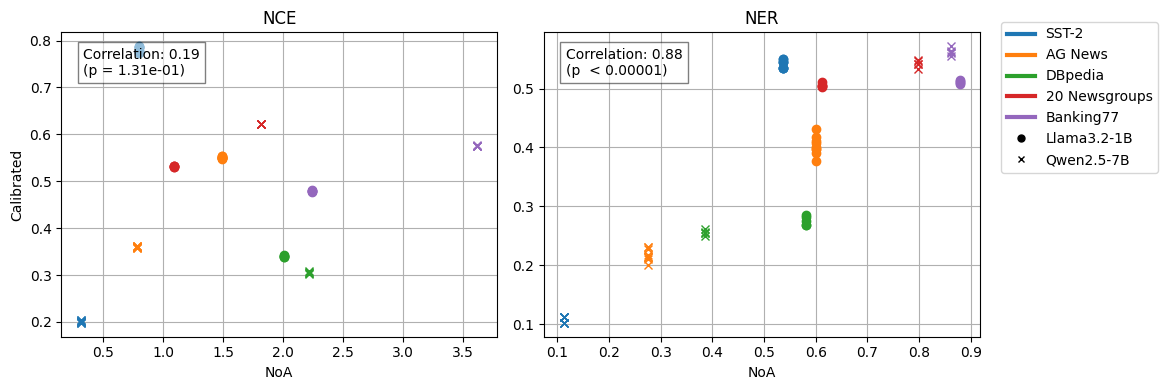

In [3]:
sorted_datasets = ["sst2", "agnews", "dbpedia", "20newsgroups", "banking77"]
dataset2name = {
    "sst2": {"label": "SST-2", "color": "tab:blue"},
    "agnews": {"label": "AG News", "color": "tab:orange"},
    "dbpedia": {"label": "DBpedia", "color": "tab:green"},
    "20newsgroups": {"label": "20 Newsgroups", "color": "tab:red"},
    "banking77": {"label": "Banking77", "color": "tab:purple"},
}
models = [("llama3.2-1b-instruct", "Llama3.2-1B", "o"), ("qwen2.5-7b-instruct", "Qwen2.5-7B", "x")]

def read_results(model, metric, cal_method):
    df = pd.read_json(f"../outputs/results_paper/{model}/{metric}.jsonl", lines=True)
    df_cal = df[(df["size"] == 256) & (df["method"] == cal_method)].drop(columns=["size", "min_result"]).copy()
    df_cal["uncal"] = 0.
    for dataset in sorted_datasets:
        df_cal.loc[df_cal["dataset"] == dataset, "uncal"] = df.loc[(df["dataset"] == dataset) & (df["method"] == "no_adaptation"), "result"].values[0]
    df_cal["delta"] = df_cal["uncal"] - df_cal["result"]
    df_cal["delta_perc"] = 100 * df_cal["delta"] / df_cal["uncal"]
    df_cal = df_cal.rename(columns={"result": "Calibrated", "uncal": "NoA", "delta": "Calibration Loss", "delta_perc": "Relative Calibration Loss"})
    return df_cal

def plot(metric, method, y="cal_loss"):

    x = "NoA"
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for model, model_name, ax in [("llama3.2-1b-instruct", "Llama3.2-1B", axes[0]), ("qwen2.5-7b-instruct", "Qwen2.5-7B", axes[1])]:
        df = read_results(model, metric, method)
        corr, p = pearsonr(df[x].values, df[y].values)
        for dataset in sorted_datasets:
            df_dataset = df[df["dataset"] == dataset]
            ax.plot(df_dataset[x], df_dataset[y], marker="o", label=dataset2name[dataset])
        ax.set_title(f"{model_name}\nCorrelation: {corr:.3f} (p={p:.2e})")
        ax.set_xlabel(x)
        ax.grid(True)

    axes[0].set_ylabel(y)    
    axes[1].legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    fig.savefig(f"../outputs/results_paper/corr_{metric}_{method}.png")

def plot_all_in_one(method, y):

    x = "NoA"
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for metric, ax in zip(["nce", "ner"], axes):
        x_values, y_values = [], []
        for model, _, marker in models:
            df = read_results(model, metric, method)
            x_values.append(df[x].values)
            y_values.append(df[y].values)
            for dataset in sorted_datasets:
                df_dataset = df[df["dataset"] == dataset]
                ax.plot(df_dataset[x], df_dataset[y], linestyle="none", marker=marker, color=dataset2name[dataset]["color"])
        x_values = np.concatenate(x_values)
        y_values = np.concatenate(y_values)
        corr, p = pearsonr(x_values, y_values)
        ax.set_title(f"{metric.upper()}")
        # text box with correlation at upper left
        p_text = "p  < 0.00001" if p < 0.00001 else f"p = {p:.2e}"
        ax.text(0.05, 0.95, f"Correlation: {corr:.2f}\n({p_text})", transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
        ax.set_xlabel(x)
        ax.grid(True)

    axes[0].set_ylabel(y)

    # Gather handles and labels from all axes
    custom_handles = []
    for dataset in sorted_datasets:
        custom_handles.append(
            plt.Line2D([0], [0], color=dataset2name[dataset]["color"], linestyle="-", linewidth=3, label=dataset2name[dataset]["label"])
        ) 
    for model, model_name, marker in models:
        custom_handles.append(
            plt.Line2D([0], [0], color="black", linestyle="none", marker=marker, markersize=5, label=model_name)
        )
    fig.legend(handles=custom_handles, loc='upper right', bbox_to_anchor=(1.17, .95), title_fontsize=12, fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(f"../outputs/results_paper/corr_allinone_{method}.png")


# metric = "nce"
metric = "ner"
# plot(metric, "dp_calibration", "Relative Calibration Loss")
# plot_all_in_one("dp_calibration", "Relative Calibration Loss")
plot_all_in_one("dp_calibration", "Calibrated")

In [49]:
datset2test = {
    "sst2": 400,
    "agnews": 400,
    "dbpedia": 700,
    "20newsgroups": 800,
    "banking77": 1000
}

for dataset, test_size in datset2test.items():
    df = pd.read_csv(f"../data/{dataset}/all.csv", header=0, index_col=0)
    test_list = np.loadtxt(f"../lists/{dataset}/test_{test_size}.txt", dtype=int)
    labels = df.loc[test_list,"label"].values
    counts = np.bincount(labels)
    print(f"{dataset}. Min count: {np.min(counts)}. Class: {np.argmin(counts)}")


sst2. Min count: 196. Class: 0
agnews. Min count: 92. Class: 0


dbpedia. Min count: 35. Class: 11
20newsgroups. Min count: 25. Class: 0
banking77. Min count: 6. Class: 1
